<a href="https://colab.research.google.com/github/imraunav/Speech-Emotion-Recognition/blob/main/Speech_Emotion_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download files from google drive using terminal commands

In [3]:
!gdown https://drive.google.com/u/0/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7  # for files
# gdown <file_id>                                 # alternative format
# gdown --folder https://drive.google.com/drive/folders/<file_id>  # for folders
# gdown --folder --id <file_id>

Downloading...
From: https://drive.google.com/u/0/uc?id=1wWsrN2Ep7x6lWqOXfr4rpKGYrJhWc8z7
To: /content/speech-emotion-recognition-ravdess-data.zip
100% 78.1M/78.1M [00:00<00:00, 93.4MB/s]


In [4]:
!unzip speech-emotion-recognition-ravdess-data.zip > op # suppressing the terminal output

In [5]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split

In [6]:
from tqdm import tqdm

In [7]:
def extract_feature(filename, mfcc, chroma, mel):
  with soundfile.SoundFile(filename) as sound_file:
    X = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate # sampling rate of the sound file
    if chroma==True:
        stft=np.abs(librosa.stft(X))
    result=np.array([])
    if mfcc==True:
        mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result=np.hstack((result, mfccs))
    if chroma==True:
        chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result=np.hstack((result, chroma))
    if mel==True:
        mel=np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result=np.hstack((result, mel))
  return result

In [8]:
emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

In [9]:
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [27]:
class_encode = {
    'calm': [1, 0, 0, 0],
    'happy': [0, 1, 0, 0],
    'fearful': [0, 0, 1, 0],
    'disgust': [0, 0, 0, 1],
}

In [28]:
def load_data(test_size=0.2):
    x,y=[],[]
    for file in tqdm(glob.glob("Actor_*/*.wav")):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(class_encode[emotion])
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [29]:
x_train,x_test,y_train,y_test=load_data(test_size=0.25)

100%|██████████| 1440/1440 [00:27<00:00, 51.63it/s]


In [30]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch

In [31]:
# y_train

In [32]:
# class MyDataset(Dataset):
#   def __init__(self, labels, ):
#     self.labels = labels
#     self.features = features

#   def __len__(self):
#     return len(self.labels)

#   def __getitem__(self, idx):
#     if torch.is_tensor(idx):
#       idx = idx.tolist()

#     return sample
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)

x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)

trainDataset = TensorDataset(x_train, y_train)
testDataset = TensorDataset(x_test, y_test)

trainDataloader = DataLoader(trainDataset, batch_size=8, shuffle=True)
testDataloader = DataLoader(testDataset)

The model

In [33]:
from torch import nn
from torch.nn import functional as F

In [34]:
x_train.shape, x_test.shape

(torch.Size([576, 180]), torch.Size([192, 180]))

In [35]:
class FCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(in_features=180, out_features=256)
    self.act1 = nn.Tanh()
    self.l2 = nn.Linear(in_features=256, out_features=128)
    self.act2 = nn.Tanh()
    self.l3 = nn.Linear(in_features=128, out_features=4)
    self.act3 = nn.Softmax(dim=1)
  def forward(self, x):
    x = self.l1(x)
    # x = F.tanh(x)
    x = self.act1(x)
    x = self.l2(x)
    # x = F.tanh(x)
    x = self.act2(x)
    x = self.l3(x)
    # x = F.softmax(x, dim=1)
    x = self.act2(x)
    return x

In [54]:
random_data = torch.rand((1, 180))

classifier = FCNN()
result = classifier(random_data)
print(result)

tensor([[-0.0401,  0.0321,  0.0311, -0.0997]], grad_fn=<TanhBackward0>)


In [55]:
print(classifier)

FCNN(
  (l1): Linear(in_features=180, out_features=256, bias=True)
  (act1): Tanh()
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (act2): Tanh()
  (l3): Linear(in_features=128, out_features=4, bias=True)
  (act3): Softmax(dim=1)
)


In [56]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [57]:
classifier.to(device)

FCNN(
  (l1): Linear(in_features=180, out_features=256, bias=True)
  (act1): Tanh()
  (l2): Linear(in_features=256, out_features=128, bias=True)
  (act2): Tanh()
  (l3): Linear(in_features=128, out_features=4, bias=True)
  (act3): Softmax(dim=1)
)

In [58]:
def train_model(model, optimizer, data_loader, loss_module, num_epochs=100):
    # Set model to train mode
    model.train()

    # Training loop
    loss_per_epoch = []
    for epoch in tqdm(range(num_epochs)):
        # print(f"Epoch: {epoch+1}/{num_epochs} ")
        running_loss = 0
        samples_per_batch = 0
        for data_inputs, data_labels in data_loader:

            # Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            # data_labels = data_labels.type(int)
            data_labels = data_labels.to(device)

            # Step 2: Run the model on the input data
            preds = model(data_inputs)

            # Step 3: Calculate the loss
            loss = loss_module(preds, data_labels)
            # loss_per_update.append(loss)

            # Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            # Step 5: Update the parameters
            optimizer.step()
            running_loss += loss.item()
            samples_per_batch += 1
        loss_per_epoch.append(running_loss/samples_per_batch)
    return loss_per_epoch

In [60]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters())
loss = train_model(classifier, optimizer, trainDataloader, loss_fn, num_epochs=1000)

100%|██████████| 1000/1000 [02:00<00:00,  8.30it/s]


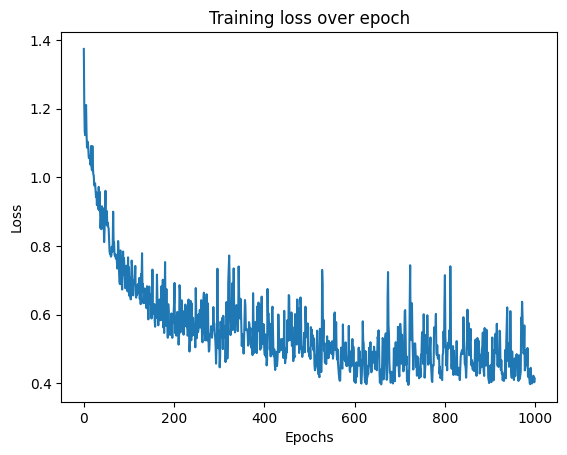

In [61]:
from matplotlib import pyplot as plt

plt.plot(loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training loss over epoch")
plt.show()

In [74]:
with torch.inference_mode():
  running_loss = 0
  acc_count = 0
  for i, (x, y) in enumerate(testDataloader):
    x = x.to(device)
    y = y.to(device)
    # step 1: forward pass
    test_pred = classifier(x)

    # step 2: Calculate loss
    test_loss = loss_fn(test_pred, y)
    if torch.argmax(test_pred) == torch.argmax(y):
      acc_count += 1

    # print(f"Test loss on sample {i}: {test_loss}")
    running_loss += test_loss.item()

  print(f"Avg. loss on test data: {running_loss/len(testDataloader)}")
  print(f"Accuracy : {acc_count/len(testDataloader)}")



Avg. loss on test data: 1.0138079887256026
Accuracy : 0.6302083333333334
